# Optimization Refresher

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from cs771 import optLib as opt
from matplotlib import pyplot as plt
import random

**Generating Toy Data 1**: let us generate two kinds of datasets on which we have seen simple classifiers struggle in the past. One will be a set of two oblique ellipsoids on which LwP failed unless it was augmented using a Mahalanobis distance. On that dataset, SVMs were found to work well. Let us see if the SVM solver we have written also works well similarly. We will use a larger number of data points i.e. set n to be a large number for this data set so that we can visualize the speed benefits of SGD and mini-batch SGD over GD.

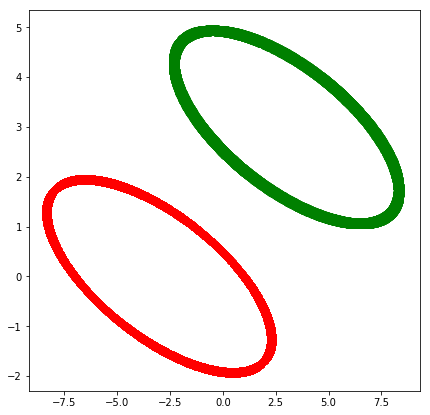

In [3]:
muPos = np.array( [-3,0] )
muNeg = np.array( [3,3] )
cov = np.array( [[16, -14] , [-14, 16]] )

d = 2 
n = 5000

XPos1 = gsd.genEllipticalData( d, n, muPos, cov )
XNeg1 = gsd.genEllipticalData( d, n, muNeg, cov )
yPos1 = np.ones( (n,) )
yNeg1 = -np.ones( (n,) )
X1 = np.vstack( (XPos1, XNeg1) )
y1 = np.concatenate( (yPos1, yNeg1) )

fig = pd.getFigure( 7, 7 )
pd.plot2D( XPos1, fig, color = 'r', marker = '+' )
pd.plot2D( XNeg1, fig, color = 'g', marker = 'o' )

**Generating Toy Data 2**: the second dataset is one that is challenging even for SVMs. This will be a set of two circles with a couple of outliers. We saw that the $C$ value in the CSVM formulation controls how worried does the CSVM get about misclassifying data points. Recall that having a very large value of $C$ can make the CSVM problem more difficult (and more time consuming) to solve. Let us see whether our solvers are able to work well for large values of $C$ or not.

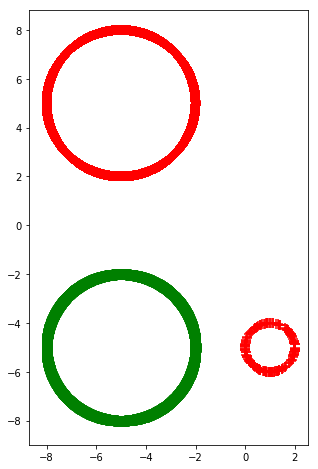

In [4]:
muPos1 = np.array( [-5,5] )
muPos2 = np.array( [1,-5] )
muNeg = np.array( [-5,-5] )
r = 3

nOutlier = n//30
rOutlier = r//2

tmp1 = gsd.genSphericalData( d, n, muPos1, r)
tmp2 = gsd.genSphericalData( d, nOutlier, muPos2, rOutlier )
XPos2 = np.vstack( (tmp1, tmp2) )
XNeg2 = gsd.genSphericalData( d, n, muNeg, r )
yPos2 = np.ones( (n + nOutlier,) )
yNeg2 = -np.ones( (n,) )
X2 = np.vstack( (XPos2, XNeg2) )
y2 = np.concatenate( (yPos2, yNeg2) )

fig2 = pd.getFigure( 5, 8 )
pd.plot2D( XPos2, fig2, color = 'r', marker = '+' )
pd.plot2D( XNeg2, fig2, color = 'g', marker = 'o' )

**Implementing Gradient Descent Variants**: below we implement four variants of the basic gradient descent algorithm. For step lengths, we are using the scheme $\eta_t = \frac\eta t$ which is recommended for functions such as the CSVM objective that satisfy a property known as "strong convexity" but are nevertheless, not differentiable. GD variants perform very well on strongly convex functions like the CSVM objective.

Note that the gradient oracles have the option of using iteration information as well. We will use this flexibility when implementing variable batch-sized SGD

1. Vanilla Gradient Descent: the word "vanilla" is often used to refer to something that is plain or simple
1. Stochastic Gradient Descent: simply choose a random data point per iteration
1. Mini-batch Stochastic Gradient Descent: choose a random (without replacement) set of $B$ samples per iteration. The batch size $B$ is a hyperparameter for this method
1. Variable Batch-size Stochastic Gradient Descent: a variant of the mini-batch stochastic gradient where batch sizes go up gradually as the optimization progresses. This makes sense -- when we begin the optimization process, we only need a rough idea of the direction in which to proceed. However, as we make more and more progress, we would ideally need less noisy directions which can be achieved by using larger batch sizes. How frequently to update the batch size and how much to increase it at each update are two hyperparameters of this method.

In [5]:
# Vanilla Gradient Descent
def getCSVMGrad( theta, t ):
    w = theta[0:-1]
    b = theta[-1]
    discriminant = np.multiply( (X.dot( w ) + b), y )
    g = np.zeros( (y.size,) )
    g[discriminant < 1] = -1
    delb = C * g.dot( y )
    delw = w + C * (X.T * g).dot( y )
    return np.append( delw, delb )

# Stochastic Gradient Descent
def getCSVMSGrad( theta, t ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    i = random.randint( 0, n-1 )
    x = X[i,:]
    discriminant = (x.dot( w ) + b) * y[i]
    g = 0
    if discriminant < 1:
        g = -1
    delb = C * n * g * y[i]
    delw = w + C * n * (x * g) * y[i]
    return np.append( delw, delb )

# Mini-batch Stochastic Gradient Descent
def getCSVMMBGrad( theta, t ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    # Be careful not to ask for more samples than there are training points
    # otherwise the sample() routine will throw an exception
    B_eff = min( B, n )
    samples = random.sample( range(0, n), B_eff )
    X_ = X[samples,:]
    y_ = y[samples]
    discriminant = np.multiply( (X_.dot( w ) + b), y_ )
    g = np.zeros( (B_eff,) )
    g[discriminant < 1] = -1
    delb = C * n/B_eff * g.dot( y_ )
    delw = w + C * n/B_eff * (X_.T * g).dot( y_ )
    return np.append( delw, delb )

# Variable Batch-size Stochastic Gradient Descent
def getCSVMVarMBGrad( theta, t ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    # Increase the batch size every few iterations -- there are two tuneable hyperparameters here
    # How frequently to update the batch size and how much to increase it at each update
    B_eff = min( B * int( pow(1.2, t//40) ), n )
    samples = random.sample( range(0, n), B_eff )
    X_ = X[samples,:]
    y_ = y[samples]
    discriminant = np.multiply( (X_.dot( w ) + b), y_ )
    g = np.zeros( (B_eff,) )
    g[discriminant < 1] = -1
    delb = C * n/B_eff * g.dot( y_ )
    delw = w + C * n/B_eff * (X_.T * g).dot( y_ )
    return np.append( delw, delb )

# Get the CSVM objective value in order to plot convergence curves
def getCSVMObjVal( theta ):
    w = theta[0:-1]
    b = theta[-1]
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w ) + b), y ), 0 )
    return 0.5 * w.dot( w ) + C * np.sum( hingeLoss )

**Case Study with the CSVM Objective**: Let us now try out our various GD solvers on the CSVM objective. CSVM problems get progressively more and more difficult as $C$ goes up. All solvers, GD/SGD/sklearn will struggle with large values of $C$. Change the values of $\eta, C$ below and experiment to observe that SGD and mini-batch SGD offer much faster convergence than GD, especially when the number of data points i.e. $n$ is large.

**Model Averaging**: GD variants, especially when executed on non-differentiable functions, often find it a bit difficult to converge very close to the global optimum, even if the function is convex. A nice way to ensure good convergence even for non-differentiable functions is to average successive iterates of the GD process and use the average model as the final output. This averaging technique can be shown to provably converge to the global optimum (proof beyond scope of CS771).

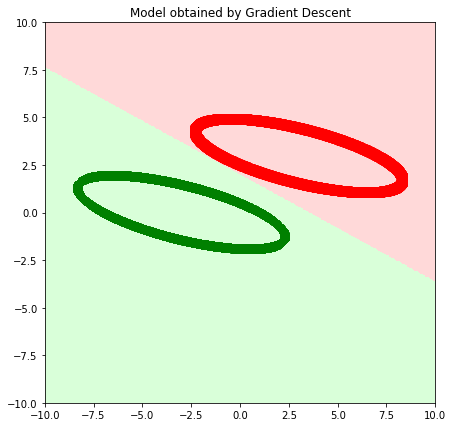

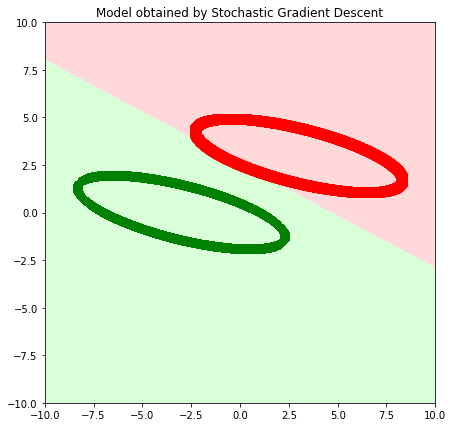

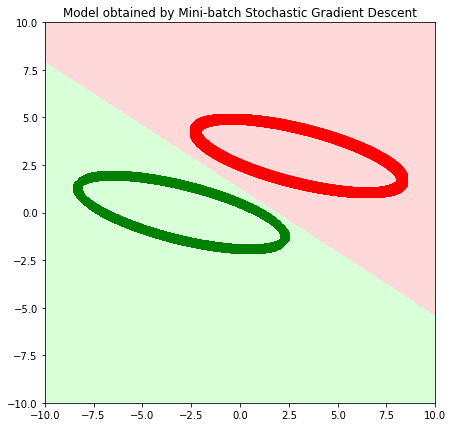

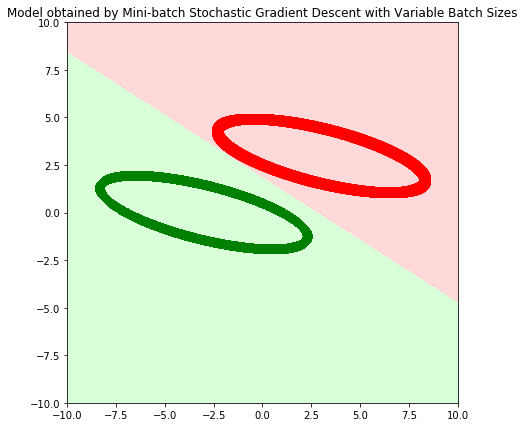

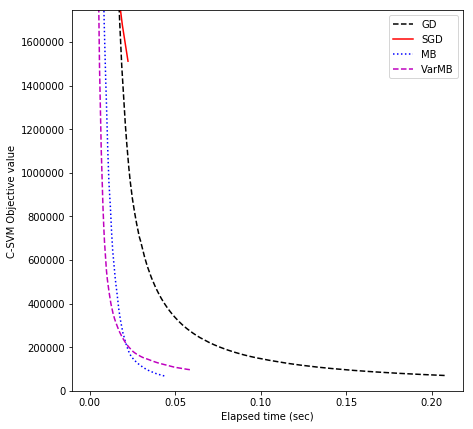

In [6]:
def mySVM( X ):
    return X.dot(w) + b

# Choose which dataset to use below
dataset = 1

if dataset == 1:
    X = X1
    y = y1
    XPos = XPos1
    XNeg = XNeg1
else:
    X = X2
    y = y2
    XPos = XPos2
    XNeg = XNeg2

C = 1
eta = 2
B = 10
init = np.zeros( (d+1,) )
stepFunc = opt.stepLengthGenerator( "linear", eta )

(thetaGD, objGD, timeGD) = opt.doGD( getCSVMGrad, stepFunc, getCSVMObjVal, init, horizon = 500, doModelAveraging = True )
(thetaSGD, objSGD, timeSGD) = opt.doGD( getCSVMSGrad, stepFunc, getCSVMObjVal, init, horizon = 500, doModelAveraging = True )
(thetaMB, objMB, timeMB) = opt.doGD( getCSVMMBGrad, stepFunc, getCSVMObjVal, init, horizon = 500, doModelAveraging = True )
(thetaVarMB, objVarMB, timeVarMB) = opt.doGD( getCSVMVarMBGrad, stepFunc, getCSVMObjVal, init, horizon = 500, doModelAveraging = True )

w = thetaGD[0:-1]
b = thetaGD[-1]

fig3 = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig3, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig3, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig3, color = 'r', marker = 'o' )
plt.title( "Model obtained by Gradient Descent" )
plt.show()

w = thetaSGD[0:-1]
b = thetaSGD[-1]

fig4 = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig4, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig4, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig4, color = 'r', marker = 'o' )
plt.title( "Model obtained by Stochastic Gradient Descent" )
plt.show()

w = thetaMB[0:-1]
b = thetaMB[-1]

fig5 = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig5, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig5, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig5, color = 'r', marker = 'o' )
plt.title( "Model obtained by Mini-batch Stochastic Gradient Descent" )
plt.show()

w = thetaVarMB[0:-1]
b = thetaVarMB[-1]

fig6 = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig6, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig6, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig6, color = 'r', marker = 'o' )
plt.title( "Model obtained by Mini-batch Stochastic Gradient Descent with Variable Batch Sizes" )
plt.show()

fig7 = pd.getFigure( 7, 7 )
plt.figure( fig6.number )
plt.plot( timeGD, objGD, color = 'k', linestyle = '--', label = "GD" )
plt.plot( timeSGD, objSGD, color = 'r', linestyle = '-', label = "SGD" )
plt.plot( timeMB, objMB, color = 'b', linestyle = ':', label = "MB" )
plt.plot( timeVarMB, objVarMB, color = 'm', linestyle = '--', label = "VarMB" )
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
plt.legend()
# Plot the results of the last blah iterates of all methods
blah = 100
plt.ylim( 0, max(objSGD[-blah], objMB[-blah], objGD[-blah], objVarMB[-blah]) )
plt.show()